In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from multiprocessing import Pool
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Split function
def split(df, label):
    return train_test_split(df, label, test_size=0.25, random_state=42)

# Generate initial population
def generate_random_population(size, n_feat):
    population = []
    for _ in range(size):
        chromosome = np.ones(n_feat, dtype=np.bool)
        chromosome[:int(0.3 * n_feat)] = False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

# Global evaluate function for multiprocessing
def evaluate(args):
    """
    Evaluate a chromosome by training a model and calculating the fitness score.
    Args:
        args: Tuple containing (chromosome, model, X_train, X_test, Y_train, Y_test, metrics)
    Returns:
        Tuple of (fitness scores as dict, chromosome)
    """
    chromosome, model, X_train, X_test, Y_train, Y_test, metrics = args
    model.fit(X_train.iloc[:, chromosome], Y_train)
    predictions = model.predict(X_test.iloc[:, chromosome])
    
    scores = {}
    for metric in metrics:
        if metric == 'accuracy':
            scores['accuracy'] = accuracy_score(Y_test, predictions)
        elif metric == 'precision':
            scores['precision'] = precision_score(Y_test, predictions, pos_label='M', zero_division=0)
        elif metric == 'recall':
            scores['recall'] = recall_score(Y_test, predictions, pos_label='M', zero_division=0)
        elif metric == 'f1':
            scores['f1'] = f1_score(Y_test, predictions, pos_label='M', zero_division=0)
    return scores, chromosome

# Fitness function with parallel processing
def fitness_parallel(population, model, X_train, X_test, Y_train, Y_test, metrics):
    """
    Evaluate the fitness of a population using parallel processing.
    Returns:
        - scores_dict: Dictionary where keys are metric names and values are lists of scores.
        - sorted_population: List of chromosomes sorted by the primary metric (first in metrics).
    """
    args = [(chromosome, model, X_train, X_test, Y_train, Y_test, metrics) for chromosome in population]
    
    with Pool() as pool:
        results = pool.map(evaluate, args)
    
    scores_list, chromosomes = zip(*results)
    chromosomes = np.array(chromosomes)
    
    # Organize scores by metric
    scores_dict = {metric: [scores[metric] for scores in scores_list] for metric in metrics}
    
    # Sort by the primary metric (first in the metrics list)
    primary_metric = metrics[0]
    sorted_indices = np.argsort(scores_dict[primary_metric])[::-1]  # Descending order
    sorted_population = chromosomes[sorted_indices]
    
    # Sort scores dictionary by the same indices
    sorted_scores_dict = {metric: np.array(scores)[sorted_indices] for metric, scores in scores_dict.items()}
    
    return sorted_scores_dict, sorted_population

# Select the best chromosomes
def selection(pop_after_fit, n_parents):
    """
    Select the top chromosomes for crossover.
    Args:
        pop_after_fit: List of chromosomes sorted by fitness.
        n_parents: Number of parents to select.
    Returns:
        List of selected chromosomes.
    """
    return list(pop_after_fit[:n_parents])  # Ensure the result is a list


# Crossover function
def crossover(pop_after_sel):
    """
    Perform crossover on the selected population.
    Args:
        pop_after_sel: List of selected chromosomes.
    Returns:
        List of new chromosomes after crossover.
    """
    # Ensure pop_nextgen is a Python list
    pop_nextgen = list(pop_after_sel)  # Convert from numpy.ndarray if needed

    for i in range(0, len(pop_after_sel) - 1, 2):
        # Get parent chromosomes
        child_1, child_2 = pop_after_sel[i], pop_after_sel[i + 1]
        
        # Perform crossover
        crossover_point = randint(1, len(child_1) - 1)
        new_child_1 = np.concatenate((child_1[:crossover_point], child_2[crossover_point:]))
        new_child_2 = np.concatenate((child_2[:crossover_point], child_1[crossover_point:]))
        
        # Add new children to the next generation
        pop_nextgen.append(new_child_1)
        pop_nextgen.append(new_child_2)

    return pop_nextgen

# Mutation function
def mutation(pop_after_cross, mutation_rate, n_feat):
    pop_next_gen = []
    for chromo in pop_after_cross:
        if np.random.rand() < mutation_rate:
            mutation_points = np.random.choice(range(n_feat), size=int(mutation_rate * n_feat), replace=False)
            chromo[mutation_points] = ~chromo[mutation_points]
        pop_next_gen.append(chromo)
    return pop_next_gen

# Genetic Algorithm generations
def generations_with_metrics(
    df, label, X_train, X_test, Y_train, Y_test, size, n_feat, n_parents,
    mutation_rate, n_gen, model, metrics=['accuracy'], patience=5
):
    best_chromo = []
    best_scores = {metric: [] for metric in metrics}
    population_nextgen = generate_random_population(size, n_feat)
    no_improve_count = 0
    best_overall_score = 0
    
    for i in range(n_gen):
        scores_dict, pop_after_fit = fitness_parallel(
            population_nextgen, model, X_train, X_test, Y_train, Y_test, metrics
        )
        
        # Extract primary metric (first in metrics list) to track progress
        primary_metric = metrics[0]
        best_current_score = scores_dict[primary_metric][0]
        
        print(f"Best scores in generation {i+1}:")
        for metric, scores in scores_dict.items():
            print(f"  {metric.capitalize()}: {scores[0]}")
        
        # Early stopping based on the primary metric
        if best_current_score > best_overall_score:
            best_overall_score = best_current_score
            no_improve_count = 0
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                print(f"Early stopping triggered at generation {i+1}")
                break
        
        # Selection, crossover, and mutation
        pop_after_sel = selection(pop_after_fit, n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross, mutation_rate, n_feat)
        
        # Store the best chromosome and scores
        best_chromo.append(pop_after_fit[0])
        for metric in metrics:
            best_scores[metric].append(scores_dict[metric][0])
    
    return best_chromo, best_scores

# Plot progress
def plot_generation_progress(scores, metric_name='Accuracy'):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(scores) + 1), scores, marker='o', linestyle='--', color='b')
    plt.title(f"Convergence of {metric_name} Scores")
    plt.xlabel("Generation")
    plt.ylabel(f"{metric_name} Score")
    plt.show()

# Save results
def save_results(best_chromo, feature_names, filename="best_features.txt"):
    selected_features = [feature_names[np.where(chromo)[0]] for chromo in best_chromo]
    with open(filename, "w") as f:
        for i, features in enumerate(selected_features):
            f.write(f"Generation {i+1} Best Features: {', '.join(features)}\n")


In [ ]:
df=pd.read_csv('wdbc')

In [7]:
df=pd.read_csv('new_data.csv')
df.head()


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [8]:
features=df.drop(columns=['diagnosis','id'])

In [9]:
label = df["diagnosis"]

In [10]:
features.head(10)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750


In [12]:
label.head(10)

0    M
1    M
2    M
3    M
4    M
5    M
6    M
7    M
8    M
9    M
Name: diagnosis, dtype: object

Best scores in generation 1:
  Accuracy: 0.986013986013986
  Precision: 0.9814814814814815
  Recall: 0.9814814814814815
  F1: 0.9814814814814815
Best scores in generation 2:
  Accuracy: 0.986013986013986
  Precision: 0.9814814814814815
  Recall: 0.9814814814814815
  F1: 0.9814814814814815
Best scores in generation 3:
  Accuracy: 0.993006993006993
  Precision: 1.0
  Recall: 0.9814814814814815
  F1: 0.9906542056074766
Best scores in generation 4:
  Accuracy: 0.993006993006993
  Precision: 0.9818181818181818
  Recall: 1.0
  F1: 0.9908256880733946
Best scores in generation 5:
  Accuracy: 0.993006993006993
  Precision: 1.0
  Recall: 0.9814814814814815
  F1: 0.9906542056074766
Best scores in generation 6:
  Accuracy: 0.993006993006993
  Precision: 1.0
  Recall: 0.9814814814814815
  F1: 0.9906542056074766
Best scores in generation 7:
  Accuracy: 0.993006993006993
  Precision: 1.0
  Recall: 0.9814814814814815
  F1: 0.9906542056074766
Best scores in generation 8:
  Accuracy: 0.993006993006993
 

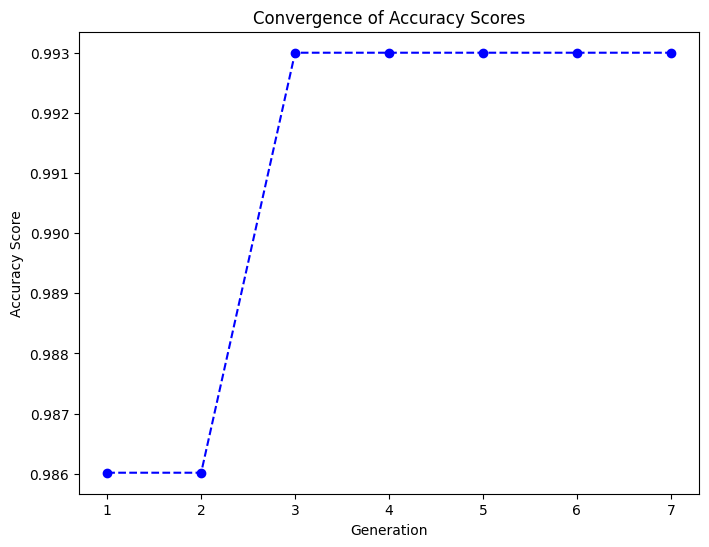

In [19]:
import multiprocessing

if __name__ == "__main__":
    multiprocessing.set_start_method("fork",force=True)  # Ensure fork is used for multiprocessing

    # Split dataset into features and labels
    X_train, X_test, Y_train, Y_test = split(features, label)

    # Run the Genetic Algorithm
    metrics_to_use = ["accuracy", "precision", "recall", "f1"]
    best_chromo, best_scores = generations_with_metrics(
        df,
        label,
        X_train,
        X_test,
        Y_train,
        Y_test,
        size=20,
        n_feat=X_train.shape[1],
        n_parents=10,
        mutation_rate=0.1,
        n_gen=50,
        model=LogisticRegression(max_iter=1000),
        metrics=metrics_to_use,
    )

    # Plot progress for the primary metric
    plot_generation_progress(best_scores["accuracy"], metric_name="Accuracy")

    # Save best results
    save_results(best_chromo, feature_names=features.columns)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, Y_train)

# Extract feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for easy visualization
importances_df = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": feature_importances}
).sort_values(by="Importance", ascending=False)

# Display the top features
print(importances_df.head(10))

                 Feature  Importance
27  concave points_worst    0.172295
23            area_worst    0.123192
7    concave points_mean    0.090299
6         concavity_mean    0.083215
20          radius_worst    0.081277
22       perimeter_worst    0.071388
2         perimeter_mean    0.053146
13               area_se    0.043551
3              area_mean    0.042780
0            radius_mean    0.039711


In [20]:
file=open('best_features.txt')
content=file.read()
print(content)

Generation 1 Best Features: perimeter_mean, area_mean, smoothness_mean, concavity_mean, concave points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, smoothness_se, compactness_se, concavity_se, concave points_se, symmetry_se, fractal_dimension_se, radius_worst, perimeter_worst, area_worst, smoothness_worst, concavity_worst, concave points_worst
Generation 2 Best Features: perimeter_mean, area_mean, smoothness_mean, concavity_mean, concave points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, smoothness_se, compactness_se, concavity_se, concave points_se, symmetry_se, fractal_dimension_se, radius_worst, perimeter_worst, area_worst, smoothness_worst, concavity_worst, symmetry_worst
Generation 3 Best Features: radius_mean, perimeter_mean, area_mean, compactness_mean, concavity_mean, fractal_dimension_mean, texture_se, perimeter_se, smoothness_se, symmetry_se, radius_worst, perimeter_worst, area_worst, smoothness_worst, compactness_worst, concavit